<a href="https://colab.research.google.com/github/Servat0r/Robotics-Project/blob/master/Robotics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Preliminary

In [1]:
%cd "/content/drive/MyDrive/Colab Notebooks"

/content/drive/MyDrive/Colab Notebooks


In [45]:
import numpy as np
import cv2
from PIL import Image
import os
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json

### Utils

In [18]:
def plot_results(history: tf.keras.callbacks.History, n_epochs=None):
    fig, ax = plt.subplots(1, 1)
    n_epochs = n_epochs or len(history.history['loss'])
    epochs = np.arange(1, n_epochs+1)
    trainLoss, validationLoss = history.history['loss'][:n_epochs], history.history['val_loss'][:n_epochs]
    ax.plot(epochs, trainLoss, label='Training Loss')
    ax.plot(epochs, validationLoss, label='Validation Loss')

### Dataset Retrieval
The original dataset is made up of $513$ `full-hd` ($1920 \times 1080$) images in `png` format. While in this format a single image requires $\approx 100$ KB of memory, a `numpy` array that contains the image in `float32` datatype will require at least $1920 \times 1080 \times 3 \times 4 \approx 24$ MB of memory, hence the whole dataset will require $\approx 12$ GB and would be unfeasible.

For simplicity, we then define a `get_dataset()` function that resizes all the images to a percentage of the original size through the `PIL.Image.Image.thumbnail()` method. By default we operate with a size of $240 \times 135$ ($12.5\%$ of original width and height values).

In [4]:
def get_dataset(
    image_data_path='data/image/ws_0.5', motion_data_path='data/motion/ws_0.5.npz',
    resize=True, force_resize=True, target_size_perc=0.125, rescale_coordinates=1,
    target_size=None,
  ): # by default 135 x 240
  if target_size:
    target_height, target_width = target_size
  else:
    target_height, target_width = int(1080 * target_size_perc), int(1920 * target_size_perc)
  resized_dir_path = os.path.join(image_data_path, f'resized_{target_height}x{target_width}')
  # Resizes images to given size
  if force_resize or (resize and not os.path.exists(resized_dir_path)):
    os.makedirs(resized_dir_path, exist_ok=True)
    pngs = sorted(list(glob.glob(f'{image_data_path}/*.png')))
    for i, png in enumerate(pngs):
      image = PIL.Image.open(png)
      image = image.resize((target_width, target_height))
      #image.thumbnail((target_width, target_height))
      image.save(os.path.join(resized_dir_path, f'{i}.png'), "PNG")
  pngs = sorted(list(glob.glob(f'{resized_dir_path}/*.png')), key=lambda x: int(x.split('/')[-1].split('.')[0]))
  images = np.zeros((len(pngs), target_height, target_width, 3), dtype=np.float32)
  for i, png in enumerate(pngs):
    images[i][:, :, :] = np.array(PIL.Image.open(png))
  motion_data = np.load(motion_data_path)
  tip_pos = rescale_coordinates * motion_data['position_rod1'][:, [2, 0, 1], -1]  # all positions of last node ([2,0,1] converts to xyz)
  return images / 255.0, tip_pos

Now a couple of hyperparameters:

In [5]:
batch_size = 32  #len(images)
resize_perc = 0.125
n_epochs = 100

In [6]:
images, tip_pos = get_dataset(target_size_perc=resize_perc, force_resize=False, rescale_coordinates=100)

Now we do *train-test split* with a validation percentage of $20\%$.

In [7]:
train_images, eval_images, train_tip_pos, eval_tip_pos = train_test_split(images, tip_pos, test_size=0.2, random_state=0)

We now define a *VGG-like* initial CNN to experiment: $5$ *VGG-blocks* (two `Conv2D` and a `MaxPool2D` layers with a kernel size of $4$ and `relu` activation) and a flattening and final `Dense` block.

In [22]:
model = tf.keras.Sequential([

  tf.keras.layers.Conv2D(8, kernel_size=4, activation='relu', padding='same', input_shape=(135, 240, 3)),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(8, kernel_size=4, activation='relu', padding='same'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(),
  #tf.keras.layers.BatchNormalization(),
  #tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(16, kernel_size=4, activation='relu', padding='same'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(16, kernel_size=4, activation='relu', padding='same'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(),
  #tf.keras.layers.BatchNormalization(),
  #tf.keras.layers.Dropout(0.3),

  tf.keras.layers.Conv2D(32, kernel_size=4, activation='relu', padding='same'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(32, kernel_size=4, activation='relu', padding='same'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(),
  #tf.keras.layers.BatchNormalization(),
  #tf.keras.layers.Dropout(0.3),

  tf.keras.layers.Conv2D(64, kernel_size=4, activation='relu', padding='same'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(64, kernel_size=4, activation='relu', padding='same'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(),
  #tf.keras.layers.BatchNormalization(),
  #tf.keras.layers.Dropout(0.3),

  tf.keras.layers.Conv2D(128, kernel_size=4, activation='relu', padding='same'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(128, kernel_size=4, activation='relu', padding='same'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(),
  #tf.keras.layers.BatchNormalization(),
  #tf.keras.layers.Dropout(0.3),

  tf.keras.layers.Flatten(),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(units=256, activation='relu'),
  tf.keras.layers.Dense(units=50, activation='relu'),
  #tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(units=3, activation='linear')
])

In [23]:
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 135, 240, 8)       392       
                                                                 
 conv2d_11 (Conv2D)          (None, 135, 240, 8)       1032      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 67, 120, 8)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 67, 120, 16)       2064      
                                                                 
 conv2d_13 (Conv2D)          (None, 67, 120, 16)       4112      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 33, 60, 16)       0         
 2D)                                                  

In [25]:
history = model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
)

Epoch 1/100
13/13 [==============================] - 5s 36ms/step - loss: 294.9266 - val_loss: 161.4788
Epoch 2/100
13/13 [==============================] - 0s 18ms/step - loss: 149.0747 - val_loss: 65.4521
Epoch 3/100
13/13 [==============================] - 0s 17ms/step - loss: 52.3264 - val_loss: 37.8978
Epoch 4/100
13/13 [==============================] - 0s 16ms/step - loss: 43.2882 - val_loss: 40.5270
Epoch 5/100
13/13 [==============================] - 0s 16ms/step - loss: 42.3546 - val_loss: 38.3077
Epoch 6/100
13/13 [==============================] - 0s 16ms/step - loss: 41.9544 - val_loss: 38.4724
Epoch 7/100
13/13 [==============================] - 0s 16ms/step - loss: 42.0008 - val_loss: 37.5598
Epoch 8/100
13/13 [==============================] - 0s 16ms/step - loss: 41.4081 - val_loss: 38.2709
Epoch 9/100
13/13 [==============================] - 0s 16ms/step - loss: 41.3988 - val_loss: 37.7635
Epoch 10/100
13/13 [==============================] - 0s 16ms/step - loss: 41.5

Now we plot the obtained results:

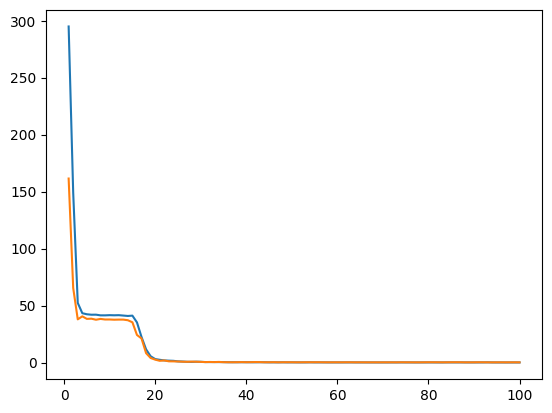

In [26]:
%matplotlib inline
plot_results(history, n_epochs=None)

We now do a simple assessment on the quality of the predictions: given an input-output couple $(x, y = [y_1, y_2, y_3])$, if $\tilde{y}$ is the value predicted by the model, we calculate the relative error: $\left[\dfrac{|y_1 - \tilde{y_1} + \epsilon|}{|y_1 + \epsilon|}, \dfrac{|y_2 - \tilde{y_2} + \epsilon|}{|y_2 + \epsilon|}, \dfrac{|y_3 - \tilde{y_3} + \epsilon|}{|y_3 + \epsilon|}\right]$, where $\epsilon = 10^{-8}$ is a small constant to avoid dividing by $0$.

In [27]:
epsilon = 1e-8
predictions = model.predict(eval_images)
differences = np.abs(predictions - eval_tip_pos - epsilon)
relative_errors = differences / np.abs(eval_tip_pos + epsilon)
relative_errors_x = relative_errors[:, 0]
relative_errors_y = relative_errors[:, 1]
relative_errors_z = relative_errors[:, 2]
print(len(relative_errors_x), len(relative_errors_y), len(relative_errors_z))
# Prune the cases of a zero target (multiplies by 10**6 the error)
relative_errors_x = relative_errors_x[eval_tip_pos[:, 0] != 0]
relative_errors_y = relative_errors_y[eval_tip_pos[:, 1] != 0]
relative_errors_z = relative_errors_z[eval_tip_pos[:, 2] != 0]
print(len(relative_errors_x), len(relative_errors_y), len(relative_errors_z))

4/4 [==============================] - 0s 6ms/step
103 103 103
102 102 103


(array([37., 24., 15.,  3.,  3.,  4.,  2.,  4.,  1.,  1.,  1.,  0.,  0.,
         1.,  1.,  0.,  0.,  0.,  0.]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <BarContainer object of 19 artists>)

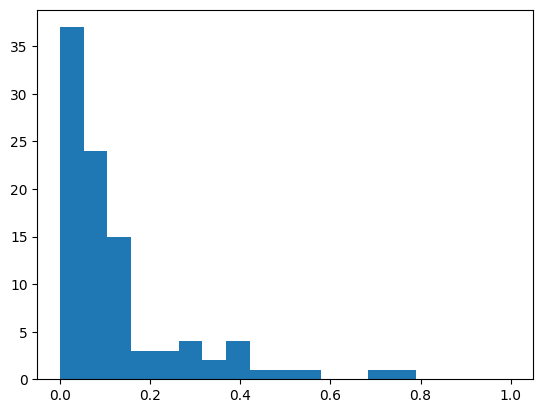

In [28]:
%matplotlib inline
plt.hist(relative_errors_x, bins=np.linspace(0, 1, 20))

(array([76., 20.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <BarContainer object of 19 artists>)

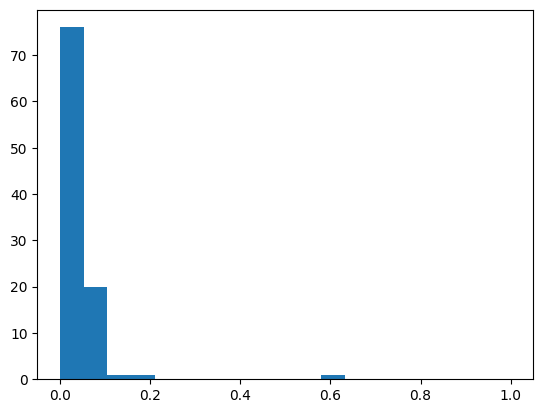

In [29]:
%matplotlib inline
plt.hist(relative_errors_y, bins=np.linspace(0, 1, 20))

(array([103.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <BarContainer object of 19 artists>)

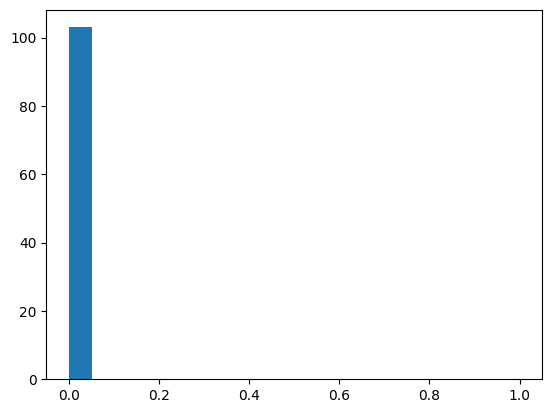

In [30]:
%matplotlib inline
plt.hist(relative_errors_z, bins=np.linspace(0, 1, 20))

In [31]:
model.save('baseVGG')

In [47]:
json.dump(history.history, open('baseVGG.json', 'w'))

### Fine-Tuning a pretrained VGG

In [32]:
%matplotlib inline
images, tip_pos = get_dataset(target_size=(224, 224), force_resize=False, rescale_coordinates=100)

(513, 224, 224, 3) float32


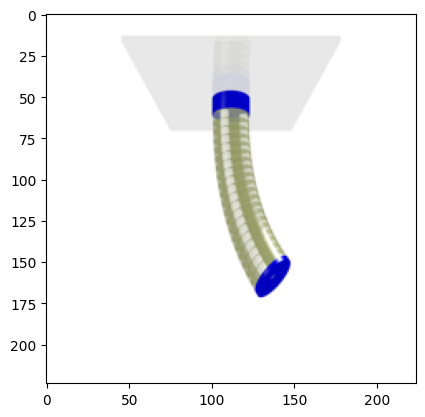

In [33]:
print(images.shape, images.dtype)
plt.imshow(PIL.Image.fromarray((255 * images[12]).astype(np.uint8)))

In [34]:
train_images, eval_images, train_tip_pos, eval_tip_pos = train_test_split(images, tip_pos, test_size=0.2, random_state=0)

In [35]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

58889256/58889256 [==============================] - 4s 0us/step


In [36]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='linear')(x)
finetuned_vgg_model = tf.keras.Model(inputs, outputs)

In [37]:
finetuned_vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 3)                 75267     
                                                                 
Total params: 14,789,955
Trainable params: 75,267
Non-trainable params: 14,714,688
_________________________________________________________________


In [38]:
finetuned_vgg_model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

In [39]:
finetuned_vgg_history = finetuned_vgg_model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
)

Epoch 1/100
13/13 [==============================] - 3s 134ms/step - loss: 57.6629 - val_loss: 31.6641
Epoch 2/100
13/13 [==============================] - 0s 31ms/step - loss: 17.9016 - val_loss: 14.0597
Epoch 3/100
13/13 [==============================] - 0s 31ms/step - loss: 9.3558 - val_loss: 6.6492
Epoch 4/100
13/13 [==============================] - 0s 31ms/step - loss: 5.0190 - val_loss: 3.6317
Epoch 5/100
13/13 [==============================] - 0s 32ms/step - loss: 3.1442 - val_loss: 2.2833
Epoch 6/100
13/13 [==============================] - 0s 32ms/step - loss: 2.0825 - val_loss: 1.4515
Epoch 7/100
13/13 [==============================] - 0s 31ms/step - loss: 1.5327 - val_loss: 1.2283
Epoch 8/100
13/13 [==============================] - 0s 31ms/step - loss: 1.2682 - val_loss: 0.8777
Epoch 9/100
13/13 [==============================] - 0s 31ms/step - loss: 1.0742 - val_loss: 1.0388
Epoch 10/100
13/13 [==============================] - 0s 31ms/step - loss: 0.9232 - val_loss: 0

In [40]:
epsilon = 1e-8
predictions = finetuned_vgg_model.predict(eval_images)
differences = np.abs(predictions - eval_tip_pos - epsilon)
relative_errors = differences / np.abs(eval_tip_pos + epsilon)
relative_errors_x = relative_errors[:, 0]
relative_errors_y = relative_errors[:, 1]
relative_errors_z = relative_errors[:, 2]
print(len(relative_errors_x), len(relative_errors_y), len(relative_errors_z))
# Prune the cases of a zero target (multiplies by 10**6 the error)
relative_errors_x = relative_errors_x[eval_tip_pos[:, 0] != 0]
relative_errors_y = relative_errors_y[eval_tip_pos[:, 1] != 0]
relative_errors_z = relative_errors_z[eval_tip_pos[:, 2] != 0]
print(len(relative_errors_x), len(relative_errors_y), len(relative_errors_z))

4/4 [==============================] - 0s 23ms/step
103 103 103
102 102 103


(array([53., 23.,  7.,  3.,  2.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  2.,
         1.,  2.,  0.,  0.,  0.,  0.]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <BarContainer object of 19 artists>)

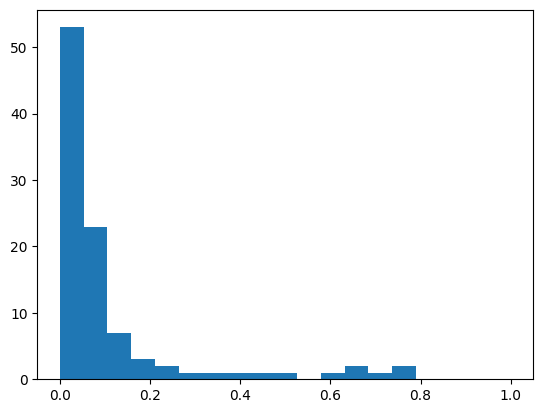

In [41]:
%matplotlib inline
plt.hist(relative_errors_x, bins=np.linspace(0, 1, 20))

(array([77., 18.,  4.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <BarContainer object of 19 artists>)

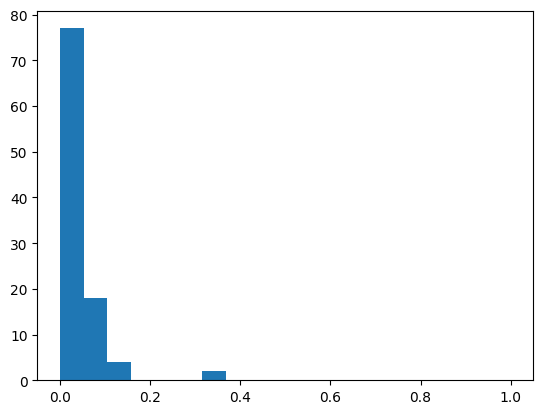

In [42]:
%matplotlib inline
plt.hist(relative_errors_y, bins=np.linspace(0, 1, 20))

(array([103.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <BarContainer object of 19 artists>)

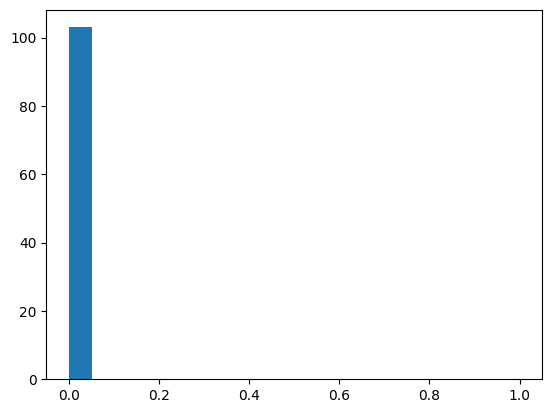

In [43]:
%matplotlib inline
plt.hist(relative_errors_z, bins=np.linspace(0, 1, 20))

In [44]:
model.save('finetunedVGG')

In [48]:
json.dump(finetuned_vgg_history.history, open('finetunedVGG.json', 'w'))

### Data Augmentation
We start with a simple `Data Augmentation` technique consisting in horizontally flipping the image. Remember that in this dataset, the camera is aligned to the `x`-axis, flipping the image to the right actually changes only the value of $y \rightarrow -y$.

* Brightness
* Saturation
* Inversion (whole image / ONLY background / ONLY foreground)
* Gaussian Noise
* Salt & Pepper

In [66]:
def apply_brightness_change(images, tip_pos, delta):
  new_images = tf.image.adjust_brightness(images, delta).numpy()
  return new_images, tip_pos.copy()

def apply_saturation_change(images, tip_pos, saturation_factor):
  new_images = tf.image.adjust_saturation(images, saturation_factor).numpy()
  return new_images, tip_pos.copy()

def apply_inversion(images, tip_pos):
  new_images = 1.0 - images
  return new_images, tip_pos.copy()

def apply_gaussian_noise(images, tip_pos, sigma=0.1):
  new_images = images.copy() + (sigma ** 2) * np.random.randn(*images.shape)
  return new_images, tip_pos.copy()

def apply_horizontal_flip(images, tip_pos):
  flipped_images = np.flip(images, axis=2)
  flipped_tip_pos = tip_pos.copy()
  flipped_tip_pos[:, 1] = -flipped_tip_pos[:, 1]
  return flipped_images, flipped_tip_pos

def apply_salt_and_pepper(images, tip_pos, prob=0.1):
  '''
  Add salt and pepper noise to image
  prob: Probability of the noise
  '''
  new_images = np.zeros(images.shape,np.float32)
  thres = 1 - prob
  randoms = np.random.uniform(0., 1., size=images.shape).astype(np.float32)
  new_images = (randoms < prob) * 0. + (randoms > thres) * 1. + (prob <= randoms) * (randoms <= thres) * images
  return new_images, tip_pos.copy()
  """
  for i in range(image.shape[0]):
      for j in range(image.shape[1]):
          rdn = random.random()
          if rdn < prob:
              output[i][j] = 0
          elif rdn > thres:
              output[i][j] = 255
          else:
              output[i][j] = image[i][j]
  """
  #return output

In [55]:
def augment_dataset(images, tip_pos, **parameters):
  new_data = [images]
  new_labels = [tip_pos]
  for param_name, param_values in parameters.items():
    func = eval(param_name)
    new_images, new_pos = func(images, tip_pos, **param_values)
    new_data.append(new_images)
    new_labels.append(new_pos)
  return np.row_stack(new_data), np.row_stack(new_labels)

In [56]:
def get_augmented_dataset(
    image_data_path='data/image/ws_0.5', motion_data_path='data/motion/ws_0.5.npz',
    resize=True, force_resize=True, target_size_perc=0.125, rescale_coordinates=1,
    target_size=None, **parameters
):
  images, tip_pos = get_dataset(
      image_data_path, motion_data_path, resize, force_resize, target_size_perc,
      rescale_coordinates, target_size
  )
  return augment_dataset(images, tip_pos, **parameters)

In [64]:
# An example configuration for augmenting dataset
augmentation_configuration = {
    'apply_brightness_change': {'delta': 0.2},
    'apply_saturation_change': {'saturation_factor': 1},
    'apply_inversion': {},
    'apply_gaussian_noise': {'sigma': 0.1},
    'apply_salt_and_pepper': {'prob': 0.1}
}

In [67]:
images, tip_pos = get_augmented_dataset(
    force_resize=False, rescale_coordinates=100, **augmentation_configuration,
)

TODO: Aggiungere stratification in base al tipo di Data Augmentation!

In [68]:
train_images, eval_images, train_tip_pos, eval_tip_pos = train_test_split(images, tip_pos, test_size=0.2, random_state=0)
print(f"Total length: {len(images)}", f"Training Set: {len(train_images)}", f"Validation Set: {len(eval_images)}", sep='\n')

Total length: 3078
Training Set: 2462
Validation Set: 616


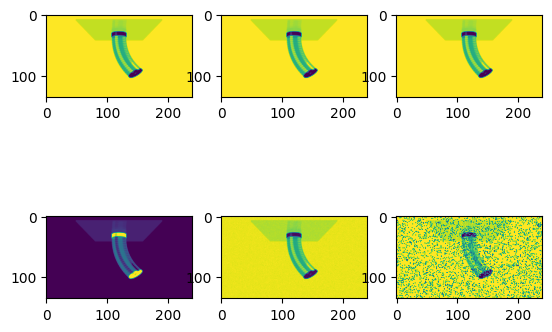

In [74]:
# Plot examples
IDX = 12
LEN = 513
fig, ax = plt.subplots(2, 3)
plt.imshow(images[0, :, :, 1])
ax[0, 0].imshow(images[IDX, :, :, 1])
ax[0, 1].imshow(images[IDX+LEN, :, :, 1])
ax[0, 2].imshow(images[IDX+2*LEN, :, :, 1])
ax[1, 0].imshow(images[IDX+3*LEN, :, :, 1])
ax[1, 1].imshow(images[IDX+4*LEN, :, :, 1])
ax[1, 2].imshow(images[IDX+5*LEN, :, :, 1])

In [75]:
model2 = tf.keras.Sequential([

  tf.keras.layers.Conv2D(8, kernel_size=4, activation='relu', padding='same', input_shape=(135, 240, 3)),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(8, kernel_size=4, activation='relu', padding='same'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(),
  #tf.keras.layers.BatchNormalization(),
  #tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(16, kernel_size=4, activation='relu', padding='same'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(16, kernel_size=4, activation='relu', padding='same'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(),
  #tf.keras.layers.BatchNormalization(),
  #tf.keras.layers.Dropout(0.3),

  tf.keras.layers.Conv2D(32, kernel_size=4, activation='relu', padding='same'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(32, kernel_size=4, activation='relu', padding='same'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(),
  #tf.keras.layers.BatchNormalization(),
  #tf.keras.layers.Dropout(0.3),

  tf.keras.layers.Conv2D(64, kernel_size=4, activation='relu', padding='same'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(64, kernel_size=4, activation='relu', padding='same'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(),
  #tf.keras.layers.BatchNormalization(),
  #tf.keras.layers.Dropout(0.3),

  tf.keras.layers.Conv2D(128, kernel_size=4, activation='relu', padding='same'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(128, kernel_size=4, activation='relu', padding='same'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(),
  #tf.keras.layers.BatchNormalization(),
  #tf.keras.layers.Dropout(0.3),

  tf.keras.layers.Flatten(),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(units=256, activation='relu'),
  tf.keras.layers.Dense(units=50, activation='relu'),
  #tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(units=3, activation='linear')
])

In [76]:
model2.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

In [77]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 135, 240, 8)       392       
                                                                 
 conv2d_21 (Conv2D)          (None, 135, 240, 8)       1032      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 67, 120, 8)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 67, 120, 16)       2064      
                                                                 
 conv2d_23 (Conv2D)          (None, 67, 120, 16)       4112      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 33, 60, 16)       0         
 g2D)                                                 

In [78]:
history2 = model2.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
)

Epoch 1/100
77/77 [==============================] - 6s 31ms/step - loss: 54.4199 - val_loss: 46.5329
Epoch 2/100
77/77 [==============================] - 1s 14ms/step - loss: 41.8032 - val_loss: 43.0409
Epoch 3/100
77/77 [==============================] - 1s 14ms/step - loss: 40.9193 - val_loss: 42.3841
Epoch 4/100
77/77 [==============================] - 1s 14ms/step - loss: 40.9996 - val_loss: 42.1162
Epoch 5/100
77/77 [==============================] - 1s 14ms/step - loss: 40.5309 - val_loss: 42.5902
Epoch 6/100
77/77 [==============================] - 1s 14ms/step - loss: 39.2277 - val_loss: 40.4602
Epoch 7/100
77/77 [==============================] - 1s 14ms/step - loss: 33.1904 - val_loss: 11.9604
Epoch 8/100
77/77 [==============================] - 1s 14ms/step - loss: 5.2496 - val_loss: 3.1537
Epoch 9/100
77/77 [==============================] - 1s 14ms/step - loss: 1.7220 - val_loss: 1.1539
Epoch 10/100
77/77 [==============================] - 1s 14ms/step - loss: 0.9741 - va

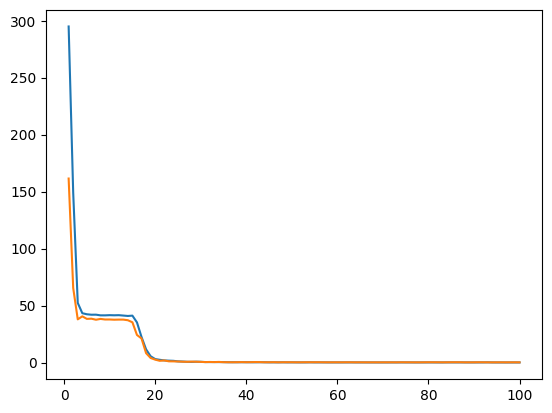

In [79]:
%matplotlib inline
plot_results(history, n_epochs)

In [80]:
epsilon = 1e-8
predictions2 = model.predict(eval_images)
differences2 = np.abs(predictions2 - eval_tip_pos - epsilon)
relative_errors2 = differences2 / np.abs(eval_tip_pos + epsilon)
relative_errors2_x = relative_errors2[:, 0]
relative_errors2_y = relative_errors2[:, 1]
relative_errors2_z = relative_errors2[:, 2]
print(len(relative_errors2_x), len(relative_errors2_y), len(relative_errors2_z))
# Prune the cases of a zero target (multiplies by 10**6 the error)
relative_errors2_x = relative_errors2_x[eval_tip_pos[:, 0] != 0]
relative_errors2_y = relative_errors2_y[eval_tip_pos[:, 1] != 0]
relative_errors2_z = relative_errors2_z[eval_tip_pos[:, 2] != 0]
print(len(relative_errors2_x), len(relative_errors2_y), len(relative_errors2_z))

20/20 [==============================] - 0s 6ms/step
616 616 616
612 612 616


(array([228.,  76.,  37.,  17.,  16.,   9.,   4.,   9.,   4.,   1.,   4.,
          3.,   2.,   5.,   0.,   2.,   0.,   0.,   0.]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <BarContainer object of 19 artists>)

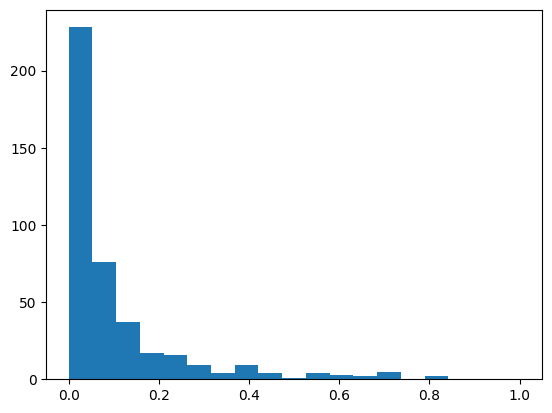

In [81]:
%matplotlib inline
plt.hist(relative_errors2_x, bins=np.linspace(0, 1, 20))

(array([267.,  93.,  34.,  16.,   7.,   6.,   7.,   4.,   6.,   4.,   8.,
          7.,   9.,   4.,   7.,   1.,   1.,   1.,   0.]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <BarContainer object of 19 artists>)

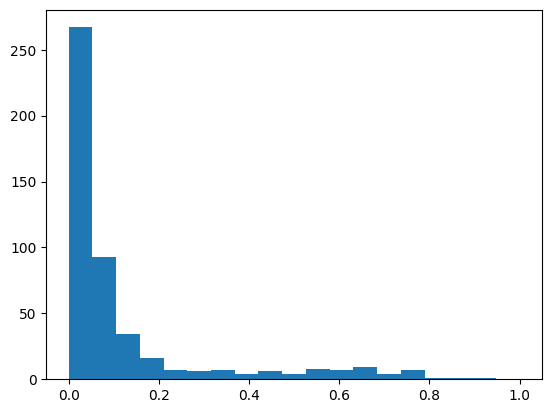

In [82]:
%matplotlib inline
plt.hist(relative_errors2_y, bins=np.linspace(0, 1, 20))

(array([327.,  90.,   1.,   2.,   3.,   5.,   5.,   8.,  18.,  32.,  21.,
         12.,   6.,   2.,   3.,   6.,   5.,   2.,   5.]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <BarContainer object of 19 artists>)

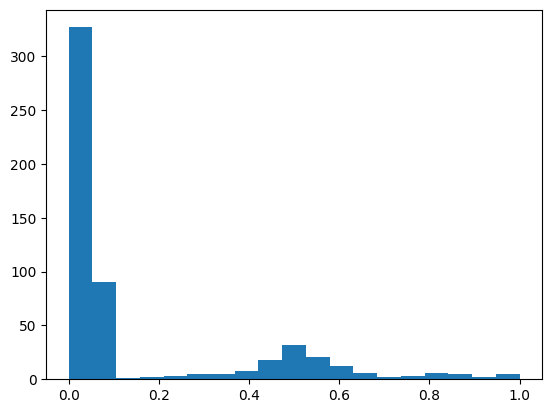

In [83]:
%matplotlib inline
plt.hist(relative_errors2_z, bins=np.linspace(0, 1, 20))

In [84]:
model2.save('dataAugmentedBaseVGG')

In [85]:
json.dump(history2.history, open('dataAugmentedBaseVGG.json', 'w'))

### Data Augmented Pretrained VGG

In [86]:
%matplotlib inline
images, tip_pos = get_augmented_dataset(
    target_size=(224, 224), force_resize=False, rescale_coordinates=100, **augmentation_configuration
)

In [93]:
train_images, eval_images, train_tip_pos, eval_tip_pos = train_test_split(images, tip_pos, test_size=0.2, random_state=0)
print(f"Total length: {len(images)}", f"Training Set: {len(train_images)}", f"Validation Set: {len(eval_images)}", sep='\n')

Total length: 3078
Training Set: 2462
Validation Set: 616


In [89]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

In [90]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='linear')(x)
augmented_finetuned_vgg_model = tf.keras.Model(inputs, outputs)

In [94]:
augmented_finetuned_vgg_model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
augmented_finetuned_vgg_history = augmented_finetuned_vgg_model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
)

Epoch 1/100
77/77 [==============================] - 5s 52ms/step - loss: 17.7839 - val_loss: 3.5771
Epoch 2/100
77/77 [==============================] - 2s 30ms/step - loss: 2.2294 - val_loss: 1.7915
Epoch 3/100
77/77 [==============================] - 2s 30ms/step - loss: 1.2684 - val_loss: 1.5199
Epoch 4/100
77/77 [==============================] - 2s 30ms/step - loss: 0.8661 - val_loss: 0.9326
Epoch 5/100
77/77 [==============================] - 2s 29ms/step - loss: 0.6203 - val_loss: 0.7834
Epoch 6/100
77/77 [==============================] - 2s 29ms/step - loss: 0.5303 - val_loss: 0.6504
Epoch 7/100
77/77 [==============================] - 2s 29ms/step - loss: 0.4142 - val_loss: 0.5932
Epoch 8/100
77/77 [==============================] - 2s 29ms/step - loss: 0.3504 - val_loss: 0.5656
Epoch 9/100
77/77 [==============================] - 2s 29ms/step - loss: 0.3121 - val_loss: 0.5094
Epoch 10/100
77/77 [==============================] - 2s 29ms/step - loss: 0.2747 - val_loss: 0.513

In [95]:
augmented_finetuned_vgg_model.save('augmentedFinetunedVGG')

In [96]:
json.dump(augmented_finetuned_vgg_history.history, open('augmentedFinetunedVGG.json', 'w'))